# How to train monkey Models

In [16]:
%load_ext autoreload
%autoreload 2

from nnfabrik.builder import get_model, get_trainer, get_data
import torch
import matplotlib.pyplot as plt

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overview

This notebook will show, how the monkey models are trained.

Steps:
1. get trainer
2. get V1 data
    - get simple CNN + Gaussian readout
    - get ResNet+Gaussian readout and train it end to end
3. get V4 data
    - get CNN + Gaussian
    - get ResNet+Gaussian, also trained end to end

#### Important: monkey data has to be on the server. Ask Konsti for details

---

## 1. trainer

In [17]:
trainer_fn, trainer_config = ('nnvision.training.trainers.nnvision_trainer',
 {'stop_function': 'get_poisson_loss',
  'maximize': False,
  'avg_loss': False,
  'device': 'cuda',
  'max_iter': 200,
  'lr_init': 0.005,
  'lr_decay_steps': 5,
  'patience': 3,
  'verbose': True,
  'adamw': True})

In [18]:
trainer = get_trainer(trainer_fn, trainer_config)

## 2. V1 data

In [19]:
dataset_fn, dataset_config = ('nnvision.datasets.monkey_loaders.monkey_static_loader_combined',
 {'dataset': 'CSRF19_V1',
  'neuronal_data_files': ['/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3631896544452.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3632669014376.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3632932714885.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3633364677437.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3634055946316.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3634142311627.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3634658447291.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3634744023164.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3635178040531.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3635949043110.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3636034866307.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3636552742293.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3637161140869.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3637248451650.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3637333931598.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3637760318484.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3637851724731.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3638367026975.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3638456653849.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3638885582960.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3638373332053.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3638541006102.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3638802601378.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3638973674012.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3639060843972.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3639406161189.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3640011636703.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3639664527524.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3639492658943.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3639749909659.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3640095265572.pickle',
   '/data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3631807112901.pickle'],
  'image_cache_path': '/data/monkey/toliaslab/CSRF19_V1/images/',
  'crop': 70,
  'subsample': 1,
  'seed': 1000,
  'time_bins_sum': 12,
  'batch_size': 128})

In [20]:
dataloaders = get_data(dataset_fn, dataset_config)

Loading images ...


Files Processing: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


In [21]:
dataloaders

{'train': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f4dac6be1f0>},
 'validation': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f4dac6c03d0>},
 'test': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f4dac6c0b20>}}

In [22]:
batch = next(iter(dataloaders["test"]["all_sessions"]))

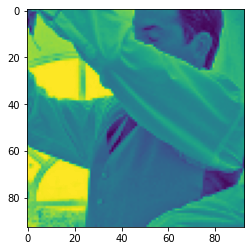

In [23]:
plt.imshow(batch.inputs[0][0])

### CNN model

In [24]:
model_fn, model_config = ('nnvision.models.se_core_full_gauss_readout',
{'pad_input': False,
   'stack': -1,
   'depth_separable': True,
   'input_kern': 32,
   'gamma_input': 10,
   'gamma_readout': 0.5,
   'hidden_dilation': 1,
   'hidden_kern': 9,
   'n_se_blocks': 0,
   'hidden_channels': 32})

In [25]:
model = get_model(model_fn, model_config, dataloaders=dataloaders, seed=0)

Connecting lbaroni@134.76.19.44:3306
datajoint connection not established, skipping model imports from nnfabrik tables


In [26]:
model.cuda().train();

### Now train

In [27]:
trainer(model, dataloaders, seed=42)

Epoch 1: 100%|██████████| 150/150 [00:08<00:00, 17.60it/s]


[001|00/03] ---> -0.2460478062811564


Epoch 2: 100%|██████████| 150/150 [00:08<00:00, 17.69it/s]


[002|00/03] ---> -0.29337159560511245


Epoch 3: 100%|██████████| 150/150 [00:08<00:00, 17.71it/s]


[003|00/03] ---> -0.30171132578088905


Epoch 4:  65%|██████▍   | 97/150 [00:05<00:02, 17.72it/s]


KeyboardInterrupt: 

### Data driven ResNet layer 1.0

In [52]:
model_fn, model_config = ('nnvision.models.ptrmodels.task_core_gauss_readout',
 {'input_channels': 1,
  'model_name': 'resnet50_l2_eps0_1',
  'layer_name': 'layer1.0',
  'pretrained': False,
  'bias': False,
  'final_batchnorm': True,
  'final_nonlinearity': True,
  'momentum': 0.1,
  'fine_tune': True,
  'init_mu_range': 0.4,
  'init_sigma_range': 0.6,
  'readout_bias': True,
  'gamma_readout': 3.0,
  'gauss_type': 'isotropic',
  'elu_offset': -1,
  'data_info': None})

In [53]:
model = get_model(model_fn, model_config, dataloaders=dataloaders, seed=0)

In [54]:
model.cuda().train();

### Now train

In [ ]:
trainer(model, dataloaders, seed=42)

---

# V4

In [56]:
dataset_fn, dataset_config = ('nnvision.datasets.monkey_loaders.monkey_static_loader_combined',
 {'dataset': 'CSRF19_V4',
  'neuronal_data_files': ['/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3653578665399.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3646222772876.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3748957662107.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3649689088057.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3712670505092.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3748441462696.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3747833727628.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3691077636469.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3652885366025.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3746022907126.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3647617982355.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3708093025461.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3722525435528.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3746535952129.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3650459721914.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3719936747145.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3693408913501.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3744900291863.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3713540419547.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3654087847388.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3733498089386.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3751467146461.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3692979440036.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3690904445724.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3648051669051.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3746107242231.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3646401671909.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3732201680940.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3749822834981.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3748614014391.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3691598527367.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3692111199445.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3744986196793.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3651417046988.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3653320713405.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3750340866612.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3709044427797.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3692803081128.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3708524807328.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3649169411059.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3712929593724.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3649252123347.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3722438565710.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3712241082384.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3751642598412.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3653924870701.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3646321567215.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3707919779504.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3750425748967.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3753367464516.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3731428171903.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3713453620500.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3653226873615.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3650037309346.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3712155848180.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3646747773987.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3713364469057.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3750168022112.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3652197206019.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3654009687031.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3753282720176.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3751986795662.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3733411059011.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3732890821596.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3732284443391.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3691166189967.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3720103503530.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3712846676126.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3692198281175.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3647439534447.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3732028703805.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3748527198188.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3747317696750.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3692716394548.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3751034032929.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3731593515335.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3649771255234.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3646924284383.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3751555475499.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3747921558292.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3648475457626.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3746626147103.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3732808128055.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3751380721375.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3646657276979.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3705414317880.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3653061170515.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3690561673793.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3645713184967.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3732717352922.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3647531807425.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3648221742562.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3690990614288.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_4722438565710.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3708698030781.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3731509601777.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3714143368022.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3648644839726.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3646146362280.pickle',
   '/data/monkey/toliaslab/CSRF19_V4/neuronal_data/CSRF19_V4_3750947602251.pickle'],
  'image_cache_path': '/data/monkey/toliaslab/CSRF19_V4/images/',
  'crop': [[18, 18], [110, 110]],
  'subsample': 1,
  'scale': 0.5,
  'seed': 1000,
  'time_bins_sum': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  'batch_size': 64,
  'include_prev_image': False,
  'include_trial_id': False,
  'img_mean': 124.34,
  'img_std': 70.28})

In [57]:
dataloaders = get_data(dataset_fn, dataset_config)

Files Processing: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


In [58]:
dataloaders

{'train': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f0277981880>},
 'validation': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f0277981eb0>},
 'test': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f027799d5b0>}}

In [59]:
batch = next(iter(dataloaders["train"]["all_sessions"]))

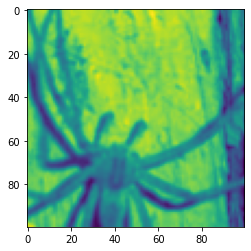

In [60]:
plt.imshow(batch.inputs[0][0])

### Data driven ResNet: Layer 3.0

In [61]:
model_fn, model_config = ('nnvision.models.ptrmodels.task_core_gauss_readout',
 {'input_channels': 1,
  'model_name': 'resnet50_l2_eps0_1',
  'layer_name': 'layer3.0',
  'pretrained': False,
  'bias': False,
  'final_batchnorm': True,
  'final_nonlinearity': True,
  'momentum': 0.1,
  'fine_tune': True,
  'init_mu_range': 0.4,
  'init_sigma_range': 0.6,
  'readout_bias': True,
  'gamma_readout': 3.0,
  'gauss_type': 'isotropic',
  'elu_offset': -1,
  'data_info': None})

In [62]:
model = get_model(model_fn, model_config, dataloaders=dataloaders, seed=0)

In [63]:
model.cuda().train();

### Now train

In [ ]:
trainer(model, dataloaders, seed=42)

### CNN

In [65]:
model_fn, model_config = ('nnvision.models.se_core_full_gauss_readout',
 {'pad_input': False,
  'gamma_readout': 0.020195561947488908,
  'gamma_input': 10,
  'layers': 5,
  'depth_separable': True,
  'n_se_blocks': 0,
  'stack': -1,
  'input_kern': 9,
  'hidden_kern': 5,
  'hidden_channels': 96,
  'init_mu_range': 0.1780563002765732,
  'init_sigma': 0.5851238789405838,
  'gauss_type': 'isotropic'})

In [66]:
model = get_model(model_fn, model_config, dataloaders=dataloaders, seed=0)

In [67]:
model.cuda().train();

In [69]:
model

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 96, kernel_size=(9, 9), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(96, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=96, bias=False)
          (out_depth_conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(96, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (i

### Now train

In [68]:
trainer(model, dataloaders, seed=42)

Epoch 1:   4%|▎         | 11/300 [00:02<00:55,  5.18it/s]


KeyboardInterrupt: 